# Домашнее задание 2
**Выполнил: Ким Адамейко, группа мАДБМ16**

In [26]:
import time
import __main__
import os
import pymol
__main__.pymol_argv = [ 'pymol', '-cp' ]
pymol.finish_launching()
from pymol import cmd
from IPython.display import Image, display, HTML
from __future__ import print_function

def prepareImage(filename='tmp.png', width=500, height=500, sleep=0.5, show=False):
    filename = filename[0] if isinstance(filename, tuple) else filename
    if filename[-3:] != 'png': filename += '.png'
    cmd.viewport(width, height) 
    cmd.ray(width, height)
    cmd.png(filename)
    time.sleep(sleep)
    if show:
        display(HTML('<img src="%s?v=%d"/>' % (filename, int(time.time()))))

def img_row(img_data):  # tuples of (filename, title)
    img_files, titles = zip(*img_data)
    display(HTML("<table>" + 
                 ('<tr>' + ''.join(['<th style="text-align: center;">' + title + '</th>' 
                                    for title in titles]) + '</tr>' if titles else '') +
                  '<tr>' + ''.join(['<td><img src="' + img + '.png?v=' + str(int(time.time())) + '"/></td>' 
                                    for img in img_files])+'</tr></table>'))

## Часть 2. Поиск водородных связей

Нужно проанализировать связи между хитоолигосахаридами и лизоцимом радужной  форели.

In [14]:
images = (('1LMP_01', 'Полная картина'), ('1LMP_02', 'Без несвязанных атомов'))
cmd.reinitialize()
cmd.fetch("1LMP", async=0)                       # загружаем файл из интернета по идентификатору PDB в синхр.режиме
prepareImage(images[0])
cmd.hide('nonbonded')                            # отключаем отображение несвязанных атомов (ионов, воды)
prepareImage(images[1])
img_row(images)

Полная картина,Без несвязанных атомов
,


С помощью сайта RCSB PDB [2] можно изучить связи между лигандами и белком, пройдя по ссылке Ligand Explorer и воспользовавшись соответствующим Java Web Start приложением. В этом приложении также можно получить карту контактов

![](ligand_explorer.png)

Попробуем получить подобные картинки с помощью PyMol

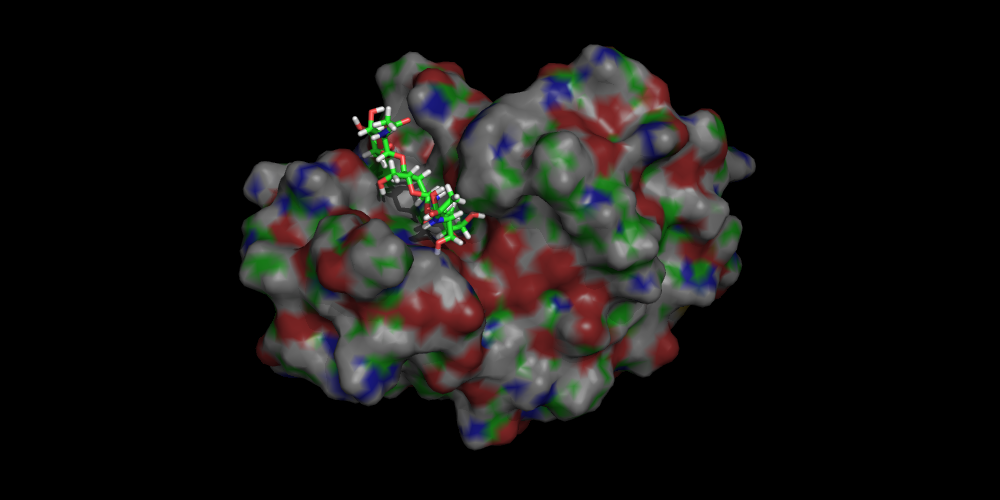

In [297]:
cmd.reinitialize()
cmd.fetch("1LMP", async=0)   
cmd.remove('solvent')                        # убираем атомы воды
cmd.h_add('all')                             # добавим водороды
cmd.extract('ligands', 'het')                # экстрагируем атомы лиганда (т.н. гетероатомы) в объект ligands
cmd.orient('1lmp')                           # ориентируем вдоль "главных осей" белка
cmd.turn('y', 200)                           # поворот (красивый угол подобрал на локальной машине)
cmd.turn('x', 30)                            # поворот
cmd.show_as('sticks', 'ligands')             # лиганд изобразим толстыми палочками
cmd.show_as('surface', '1lmp')               # белок изобразим в виде полупрозрачной поверхности
cmd.set('transparency', 0.5)
prepareImage('1LMP_03', 1000, 500, show=True)

Приблизим участок взаимодействия, изобразим:
* остатки в пределах 4 Å от лиганда 
* водородные связи (по [3]) между электроотрицательными атомами белка и лигандом с помощью функции distance() 
 * c максимальной длиной связи 3.2 Å (общепринятый порог, который, однако, не гарантирует правильность всех построенных связей) 
 * и режимом 2. 
* подписи к взаимодействующим атомам белка, которые позволят идентифицировать остатки
 
Посмотрим на лиганд вдоль двух "осей" сайта связывания

In [298]:
cmd.set('transparency', 1)
cmd.select('don', '(elem n,o and (neighbor hydro))')                      # доноры
cmd.select('acc', '(elem o or ((elem n) and (not (neighbor hydro))))')    # акцепторы
cmd.distance('HBA', '(ligands and acc)', '(1lmp and don)', 3.2, 2)        # связи, где акцепторы в лиганде
cmd.distance('HBD', '(ligands and don)', '(1lmp and acc)', 3.2, 2)        # связи, где акцепторы в белке
cmd.set('label_color', 'white', 'HBA')                                    # цвет и размер шрифта подписей на связях
cmd.set('label_color', 'white', 'HBD')            
cmd.set('label_size', 16)

cmd.reset()                                          # сброс ориентации камеры
cmd.show('lines', 'byres(1lmp w. 4 of ligands)')     # покажем близлежащие к лиганду атомы белка тонкими линиями
cmd.set('label_shadow_mode', 0)                      # чтобы подписи не отбрасывали теней
cmd.select('contact', '(((acc or don) within 3.5 of ligands) and (not ligands))') # атомы белка, конт.через вод/св
cmd.do('label contact, "(%s, %s)" % (resn, resi)')                                # пометим их (назв, номер остатка)

cmd.orient('ligands')                                # сориентируем вдоль главной "оси" лиганда
cmd.turn('x', -90)                                   # доп. повороты (подбирались на локальной машине)
cmd.zoom('ligands')                                 
prepareImage('1LMP_04', 600, 400)
cmd.turn('y', -100)                                  # вид сбоку
cmd.zoom('ligands')
prepareImage('1LMP_05', 400, 400)
img_row([('1LMP_04','Вид вдоль главной оси лиганда'), ('1LMP_05','Вид сбоку')])

Вид вдоль главной оси лиганда,Вид сбоку
,


## Часть 3. Мутагенез

Рассмотрим, например, аспаргинин в позиции 52, он находится в близком контакте с лигандом (расстояние ~1.5 Å). Мутируем этот остаток так, чтобы он занимал больше пространства, и т.к. в этой части "кармашка" белка лиганду разворачиваться или двигаться особенно негде, можно предположить, что связь будет потеряна. Можно взять, например, аргинин, однако заметим, что для такой мутации остатка замена должна произойти в двух нуклеотидах.

In [299]:
images = [('mut_before', 'До мутации'), ('mut_after', 'После мутации')]
mut_resi = 52                  # выбор исходного остатка по номеру
mutable_where_to = 'ARG'       # выбор целевого остатка по названию
cmd.select('mut', 'resi %d or ligands within 5 of resi %d' % (mut_resi, mut_resi)) # выбор области для зума
cmd.zoom('mut')
cmd.orient('mut')
cmd.turn('x', 90)   
cmd.colour('purple','resi %d' % mut_resi )                  # окрашиваем и утолщаем мутируемый остаток, 
cmd.show_as('sticks','resi %d' % mut_resi )                 # чтобы сделать его заметнее
prepareImage(images[0], 500,400)

cmd.wizard("mutagenesis")                                   # основной код процедуры мутации
cmd.do("refresh_wizard")                                         
cmd.do('cmd.get_wizard().do_select("resi %d")' % mut_resi)  # выбор мутируемого остатка
cmd.do('cmd.get_wizard().set_mode("%s")' % mutable_where_to)# выбор целевого остатка
cmd.do("refresh_wizard")
cmd.do("cmd.get_wizard().apply()")                          # применение мутации
cmd.do("cmd.set_wizard()")
cmd.colour('orange','resi %d' % mut_resi )                  # снова окрашиваем
cmd.move('x', -3)                                           # компенсируем сдвиг камеры (причину не выяснил)
prepareImage(images[1], 500, 400)
img_row(images)

До мутации,После мутации
,


In [225]:
cmd.save( "./1lmp_mut.pdb", 'all')

## Часть 4. Анимация
Для начала скачаем утилиту ffmpeg для создания видео из картинок

In [18]:
%%bash
if ! hash ffmpeg 2>/dev/null; then
   mkdir -p '../bin/ffmpeg/'
   if [ ! -f '../bin/ffmpeg/ffmpeg.tar.xz' ] ; then
       echo 'loading...'
       wget -nv -O '../bin/ffmpeg/ffmpeg.tar.xz' https://johnvansickle.com/ffmpeg/releases/ffmpeg-release-32bit-static.tar.xz
   fi
   echo 'extracting...'
   tar xJf '../bin/ffmpeg/ffmpeg.tar.xz' -C '../bin/ffmpeg/' --strip-components 1
   rm '../bin/ffmpeg/ffmpeg.tar.xz'
   echo 'done.'
fi
chmod 755 -R '../bin/ffmpeg/'

* Загрузим оригинальный и мутированный белок
* Подготовим объекты выделения для удобной манипуляции
* Раскрасим белки и лиганды, лиганды и место мутации покажем толстыми палочками

In [16]:
cmd.reinitialize()
mut_resi = 52                  # выбор исходного остатка по номеру
cmd.fetch('1lmp', 'ori')
cmd.load('./1lmp_mut.pdb', 'mut')
cmd.remove('solvent')                        # убираем атомы воды
cmd.h_add('all')                             # добавим водороды

cmd.select('lig1', 'ori and het')
cmd.select('lig2', 'mut and het')
cmd.select('res', 'resi %d' % mut_resi)
cmd.select('mutspot', 'res +  (lig* within 5 of res)')

cmd.hide('everything')
cmd.show('lines', '(mut | ori) & !lig*')
cmd.show('sticks', 'lig* | res')
cmd.colour('olive', 'mut')
cmd.colour('silver', 'ori')
cmd.colour('skyblue', 'lig*')
cmd.colour('purple', 'ori & res')
cmd.colour('orange', 'mut & res')
cmd.set('transparency', 0.7)

* Подготовим стартовый кадр. Пока ещё не снимаем фильм, можно использовать `translate()` без именованного параметра object!

In [12]:
width, height = 600, 300
cmd.orient('mutspot')
cmd.turn('x', 60)  
cmd.turn('y', 10)
cmd.translate('[-50, 0, 0]', 'mut')
cmd.zoom('*', -14)
cmd.move('x',-4) 
prepareImage('tmp', width, height, show=True)

* Дальнейшая последовательность действий сначала долго оттачивалась на локальном компьютере. Некоторый опыт...
    * Не все команды возможно корректно исполнить вне простой обёртки `cmd.do()`, сначала я пытался, потом сдался. Особенно это касается именованного параметра `object`, который не может быть заменён позиционным вторым параметром, отвечающим за выделение -- это не сработает при съёмке фильма!
    * Функции `util.mrock()` и `util.mroll()` я не смог заставить выдать результат, который мне бы понравился, поэтому вращал сцену вручную. 
    * Иногда, если переходить к новому кадру слишком быстро, пока Pymol не успел интерполировать предыдущие, в этом новом кадре сцена может быть выставлена некорректно. Решил проблему отключением авто-интерполяции.

In [14]:
n_frames = 360
cmd.set('matrix_mode', 1)
cmd.set('ray_trace_frames', '0')
cmd.set('movie_auto_interpolate', '0')
cmd.viewport(width, height) 
cmd.mset('1 x%d' % n_frames)

cmd.frame('1')
cmd.mview('store')
cmd.do('mview store, object=mut')

cmd.frame('%d' % (n_frames // 5))
cmd.do('translate [30, 0, 0], object=mut')
cmd.center('mutspot')
cmd.zoom('*', -10)
cmd.mview('store')
cmd.do('mview store, object=mut')

cmd.frame('%d' % (n_frames // 2))
cmd.do('translate [20, 0, 0], object=mut')
cmd.do('mview store, object=mut')
cmd.zoom('mutspot', -2)
cmd.mview('store')

cmd.frame('%d' % (n_frames))
cmd.do('mview store, object=mut')
cmd.zoom('mutspot', -2)
cmd.center('mutspot')
cmd.mview('store')

cmd.frame(n_frames//3)
cmd.center('mutspot')
cmd.zoom('mutspot', -2)
cmd.mview('store')

for i in range(n_frames//2+1, n_frames+1, 2):
    cmd.frame(i)
    cmd.do('turn y, -8')
    cmd.mview('store')

cmd.do('mview interpolate')
cmd.do('mview interpolate, object=mut')

* Сохраним кадры и выведем несколько ключевых, чтобы проверить, что всё хорошо

In [15]:
! mkdir -p ./frames/
! rm ./frames/*
cmd.set('ray_trace_frames', '1')
cmd.set('antialias', '1')
cmd.mpng('./frames/1lmp_frame')

In [155]:
images = []
for i in [7, 5, 3, 2]:
    frame_name = '1lmp_frame%04d' % (n_frames // i)
    ! cp './frames/{frame_name}.png' './{frame_name}.png'
    images.append(('./' + frame_name, ''))
img_row(images)

,,,
,,,


* Наконец, собираем фильм

In [17]:
! '../bin/ffmpeg/ffmpeg' -y -i './frames/1lmp_frame%04d.png' -c:v libx264 -pix_fmt yuv420p -vf "scale=trunc(iw/2)*2:trunc(ih/2)*2" movie_1lmp.mp4
! rm ./frames/*

In [24]:
HTML('<video controls alt="PyMol Movie" src="movie_1lmp.mp4?" type="video/mp4">')

## Часть 5. Метка TAMRA
Сложноэфирная связь: $\require{mhchem}\ce{R-COOH + HO-R' <=>[H+] R-COO-R' + H2O}$

Загрузим метку TAMRA, видим там карбоксильную группу ($\ce{-COOH}$)

In [9]:
! wget -nv -O './tamra.sdf' 'https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/2762604/record/SDF/?response_type=save&record_type=3d'

2017-12-24 15:26:42 URL:https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/2762604/record/SDF/?response_type=save&record_type=3d [7912] -> "./tamra.sdf" [1]


In [113]:
cmd.reinitialize()
cmd.load('./tamra.sdf', 'tamra')
cmd.show('sticks')
cmd.zoom('*')
prepareImage('tamra_1', 500, 300)
cmd.turn('x', 60)
cmd.turn('y', 120)
prepareImage('tamra_2', 500, 300)
img_row([('tamra_1',''), ('tamra_2','')])

,
,


Затем загрузим снова наш белок, выделим все остатки *серина и треонина* (они содержат гидроксильную группу $\ce{-OH}$), находящиеся на поверхности белка. Нижеследующий скрипт, который отбирает такие остатки, взят с сайта PymolWiki [6]

In [63]:
%%writefile ./find_surface_residues.py
import pymol
from pymol import cmd, stored
import random

# https://pymolwiki.org/index.php/FindSurfaceResidues
def findSurfaceResidues(objSel="(all)", cutoff=2.5, doShow=False, verbose=False):
    tmpObj="__tmp"
    cmd.create( tmpObj, objSel + " and polymer");
    if verbose!=False:
        print("WARNING: I'm setting dot_solvent.  You may not care for this.")
    cmd.set("dot_solvent");
    cmd.get_area(selection=tmpObj, load_b=1)
    cmd.remove( tmpObj + " and b < " + str(cutoff) )

    stored.tmp_dict = {}
    cmd.iterate(tmpObj, "stored.tmp_dict[(chain,resv)]=1")
    exposed = stored.tmp_dict.keys()
    exposed.sort()

    randstr = str(random.randint(0,10000))
    selName = "exposed_atm_" + randstr
    if verbose!=False:
        print("Exposed residues are selected in: " + selName)
    cmd.select(selName, objSel + " in " + tmpObj ) 
    selNameRes = "exposed_res_" + randstr
    cmd.select(selNameRes, "byres " + selName )

    if doShow!=False:
        cmd.show_as("spheres", objSel + " and poly")
        cmd.color("white", objSel)
        cmd.color("red", selName)
    cmd.delete(tmpObj)
    return exposed


cmd.extend("findSurfaceResidues", findSurfaceResidues)

In [114]:
cmd.disable('tamra')
cmd.set('label_size', 16)
cmd.set('label_shadow_mode', 0)

cmd.fetch('1lmp')
cmd.remove('solvent')                        
cmd.h_add('all')                             
cmd.hide('all')
cmd.select('prot', '!het')

cmd.do('run ./find_surface_residues.py')
cmd.do('findSurfaceResidues')
cmd.select('all_thr_ser', '(resn thr | resn ser) & exposed_res*')
cmd.do('label n. CA & all_thr_ser, "(%s, %s)" % (resn, resi)')
cmd.show('cartoon', 'all')
cmd.show('sticks', 'all_thr_ser')
cmd.orient('all_thr_ser')
cmd.zoom('all_thr_ser', -4)
cmd.deselect()
prepareImage('1LMP_06', 500, 300)
cmd.turn('y', 180)
prepareImage('1LMP_07', 500, 300)
img_row([('1LMP_06',''), ('1LMP_07','')])

,
,


Выберем, например, треонин, остаток номер 47. 
* Для совмещения выбираю кислород в гидроксильной группе треонина и углерод в карбоксильной группе TAMRA-метки. 
* Сделав первые опыты, замечаю, что *гидроксильная группа треонина не удаляется автоматически,* что приводит к формированию странной связи. Удаляю её, выделяя соответствующие атомы в треонине. 
* Для формирования связи TAMRA-метка копируется. Чтобы выделить атомы копии, можно обратиться к ним по имени `/1LMP///UNK/` ("unknown residue")

In [115]:
fusion_resi = '/1lmp//A/THR`47'
cmd.select("link_resi", "n. CB in %s" % (fusion_resi))
cmd.select("link_tamra", "n. O in tamra within 1 of n. H")

cmd.extract('hydroxyl', fusion_resi + '/H01 | ' + fusion_resi + '/OG1')
cmd.delete('hydroxyl')

cmd.fuse('link_tamra', 'link_resi')

cmd.select('fuse_tamra', '/1LMP///UNK/')
cmd.select('fuse_region', 'fuse_tamra | ' + fusion_resi)
cmd.deselect()
cmd.hide('all')
cmd.show('lines', 'prot & !fuse_region')
cmd.show('sticks', 'fuse_region')
cmd.turn('y', -20)
prepareImage('1LMP_08', 500, 300, show=True)

* Посмотрим издалека и увидим, что метка врезается в белок. К сожалению, готовой функции, детектирующей коллизии, я не нашёл, поэтому менял торсионный угол, "на глаз" подбирая оптимальное значение. В данном случае достаточно было повернуть на 180°

In [117]:
cmd.orient('fuse_region')
cmd.zoom('fuse_region', 2)
cmd.turn('y', 20)
prepareImage('1LMP_10', 500, 300)
cmd.turn('y', 180)
prepareImage('1LMP_11', 500, 300)
img_row([('1LMP_10',''), ('1LMP_11','')])

,
,


In [118]:
cmd.torsion(180)

In [119]:
cmd.orient('fuse_region')
cmd.zoom('fuse_region', 2)
cmd.turn('y', 120)
prepareImage('1LMP_12', 500, 300)
cmd.turn('y', 180)
prepareImage('1LMP_13', 500, 300)
img_row([('1LMP_12',''), ('1LMP_13','')])

,
,


## Часть 6. Альфа-спираль
Я решил попробовать сделать поли-пролиновую альфа-спираль, поскольку пролин выделяется среди остальных аминокислот на [картах Рамачандрана](https://upload.wikimedia.org/wikipedia/commons/6/63/Ramachandran_plot_Pro.jpg)

In [123]:
cmd.reinitialize()
aa = 'pro' # пролин
cmd.fragment(aa)

# торсионные углы альфа-спирали
phi, psi = -60, -25

cmd.edit("i. %i & n. C" % 2)
cmd.edit("i. 2 & n. CA", "i. 2 & n. C")

n = 100 # число аминокислот в цепи

for i in range(2, n+1): # Присоединение аминокислот
    cmd.edit("i. %i & n. C" % i)
    cmd.do('editor.attach_amino_acid("pk1", "%s")' % aa)
    time.sleep(0.1)

for i in range(2, n+1): # Установка торсионных углов
    cmd.set_dihedral("i. %i & n. N" % i, "i. %i & n. CA" % i,
                     "i. %i & n. C" % i, "i. %i & n.  N" % (i+1), phi)
    cmd.set_dihedral("i. %i & n.  C" % i,     "i. %i & n. N" % (i+1),
                     "i. %i & n. CA" % (i+1), "i. %i & n. C" % (i+1), psi)

In [129]:
cmd.orient()
cmd.zoom('pro', -35)
prepareImage('poly_pro_01', 900, 200, show=True)

In [130]:
cmd.do('rotate z, 90, object=pro')
cmd.do('rotate x, 90, object=pro')
prepareImage('poly_pro_02', 500, 500, show=True)

## Использованные источники
1. [Образец использования Pymol на удалённом сервере](http://kodomo.cmm.msu.ru/~golovin/ipynb/ipymol-kodomo.html)
1. [1LMP в базе данных RCSB PDB](http://www.rcsb.org/pdb/explore.do?structureId=1lmp)
1. [PymolWiki: Hydrogen bonds](https://pymolwiki.org/index.php/Displaying_Biochemical_Properties#Hydrogen_bonds_and_Polar_Contacts)
1. [PymolWiki: Movie School](https://pymolwiki.org/index.php/MovieSchool_2)
1. [PymolWiki: Simple scripting](https://pymolwiki.org/index.php/Simple_Scripting)
1. [PymolWiki: Find Surface Residues](https://pymolwiki.org/index.php/FindSurfaceResidues)